In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.2f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

01_14_LGHV_Modeling_afterFE2.ipynb 에서의 모델링을 통해 나온 상위 7개 Features로 모델링 진행

#### ✅ 3차 선정된 Features

| Feature |
|---------|
| `TOTAL_USED_DAYS` |
| `CH_LAST_DAYS_BF_GRP` |
| `TV_I_CNT` |
| `AGE_GRP10` |
| `VOC_STOP_CANCEL_MONTH1_YN` |
| `CH_HH_AVG_MONTH1` |
| `MONTHS_REMAINING` |

해당 Feature들을 가지고 **모델링을 한 번 더 진행!!**


---

In [3]:
df_real = pd.read_csv("data/full_data/TPS_cancel_data_FeatureEngineering_end.csv")

In [4]:
# 해당 컬럼들 들고오기

df = df_real.filter(items=['sha2_hash','TOTAL_USED_DAYS','TV_I_CNT','CH_LAST_DAYS_BF_GRP',
                           'VOC_STOP_CANCEL_MONTH1_YN','AGE_GRP10',
                 'CH_HH_AVG_MONTH1','MONTHS_REMAINING','p_mt','churn'])

In [5]:
df.columns

Index(['sha2_hash', 'TOTAL_USED_DAYS', 'TV_I_CNT', 'CH_LAST_DAYS_BF_GRP',
       'VOC_STOP_CANCEL_MONTH1_YN', 'AGE_GRP10', 'CH_HH_AVG_MONTH1',
       'MONTHS_REMAINING', 'p_mt', 'churn'],
      dtype='object')

---

### 랜덤 언더 샘플링 데이터로 진행
1. 로지스틱
2. 랜덤 포레스트
3. XGB
4. LGBM
5. Cat

#### 1. LR 랜덤 언더 샘플링 데이터

In [7]:
# 2월 ~ 9월 train
# 6월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,7,8,9])]
val = df[df['p_mt'] == 6]
test = df[df['p_mt'] == 11]

In [8]:
train

,sha2_hash,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,733,3.00,3개월내없음,N,60대,0.00,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,764,3.00,일주일내,N,60대,6.72,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,794,3.00,3주일전,N,60대,9.86,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,825,3.00,4주일전,N,60대,5.95,10,5,N
5,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,886,3.00,일주일내,N,60대,2.93,8,7,N
...,...,...,...,...,...,...,...,...,...,...
21483370,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2215,1.00,일주일내,N,50대,2.42,-36,4,N
21483371,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2246,1.00,일주일내,N,50대,3.67,-37,5,N
21483373,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2307,1.00,일주일내,N,50대,4.10,-39,7,N
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2338,1.00,일주일내,N,50대,2.03,-40,8,N


In [9]:
train = train.drop(columns=['sha2_hash','p_mt'])
val = val.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])

In [10]:
from imblearn.under_sampling import RandomUnderSampler

X = train.drop(columns = ['churn'])
y = train['churn']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [11]:
print("Before RU:")
print(y.value_counts())

print("\nAfter RU:")
print(pd.Series(y_resampled).value_counts())

Before RU:
churn
N    13599467
Y       92454
Name: count, dtype: int64

After RU:
churn
N    92454
Y    92454
Name: count, dtype: int64


In [12]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='churn')

resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

In [13]:
train = resampled_data

In [14]:
categorical_cols = train.select_dtypes(include=['object']).columns

# Train에는 없고 Validation에만 있는 값 찾기
unseen_values = {}

for col in categorical_cols:
    train_unique = set(train[col].unique())
    val_unique = set(val[col].unique())

    unseen = val_unique - train_unique
    if unseen:
        unseen_values[col] = unseen

# 결과 출력
print(unseen_values)

{}


In [15]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [16]:
display(train)
display(val)
display(test)

,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,churn
0,2926,2.00,3,0,5,0.01,-23,0
1,3631,2.00,1,0,5,0.00,10,0
2,1728,3.00,4,0,4,6.11,16,0
3,1825,2.00,4,0,3,0.91,8,0
4,1610,3.00,4,0,3,6.28,20,0
...,...,...,...,...,...,...,...,...
184903,3712,2.00,4,0,5,1.90,30,1
184904,501,2.00,1,0,2,0.00,20,1
184905,11,2.00,4,0,4,3.49,36,1
184906,231,1.00,5,0,4,0.62,29,1


,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,churn
4,855,3.00,4,0,5,4.03,9,0
15,4249,2.00,4,0,4,18.08,12,0
26,2488,6.00,4,0,5,1.09,25,0
37,1836,3.00,4,0,5,1.32,-5,0
48,3826,4.00,4,0,4,1.27,-46,0
...,...,...,...,...,...,...,...,...
21483328,3446,2.00,0,0,4,1.72,-43,0
21483339,2128,3.00,4,0,3,2.12,-34,0
21483350,3805,2.00,4,0,2,0.73,-104,0
21483361,1399,2.00,4,0,4,4.37,24,0


,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,churn
9,1008,3.00,4,0,5,6.23,33,0
20,4402,2.00,4,0,4,15.37,7,0
31,2641,6.00,4,0,5,1.47,20,0
42,1989,3.00,4,0,5,2.16,-10,0
53,3979,4.00,4,0,4,1.64,-51,0
...,...,...,...,...,...,...,...,...
21483333,3599,2.00,1,0,4,0.00,-48,0
21483344,2281,3.00,4,0,3,1.81,-39,0
21483355,3958,2.00,4,0,2,1.69,-109,0
21483366,1552,2.00,4,0,4,3.39,19,0


In [17]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [18]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
#
model = LogisticRegression(solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Validation Accuracy: 0.79

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.79      0.88   1941863
           1       0.02      0.63      0.04     13252

    accuracy                           0.79   1955115
   macro avg       0.51      0.71      0.46   1955115
weighted avg       0.99      0.79      0.88   1955115


Confusion Matrix (Validation):
[[1535906  405957]
 [   4933    8319]]


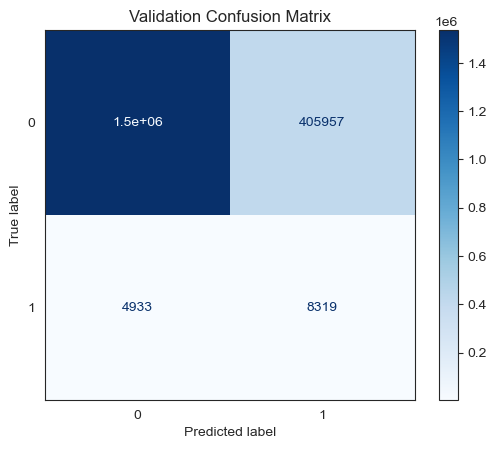

Validation AUC-ROC: 0.77


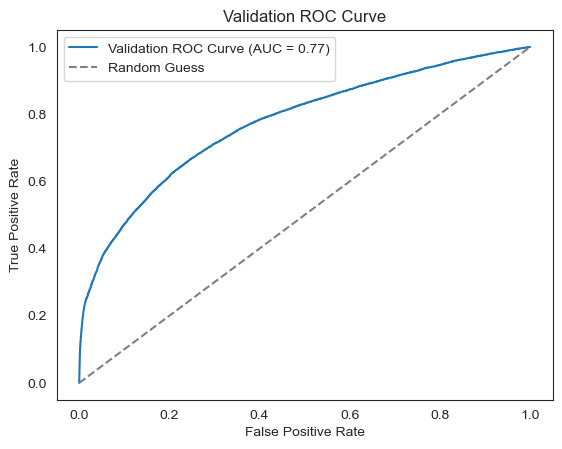

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

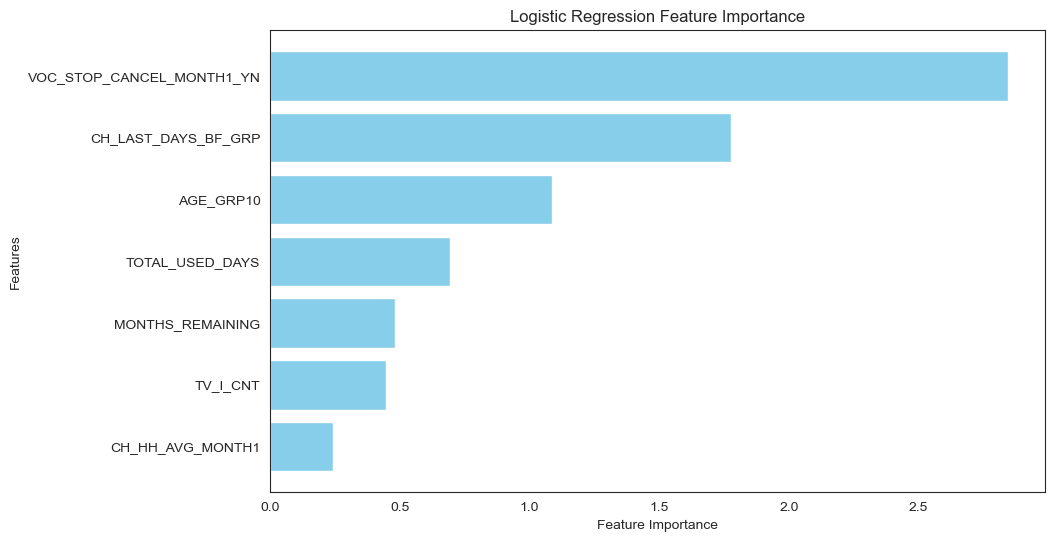

✅ Feature Importance
1. VOC_STOP_CANCEL_MONTH1_YN
2. CH_LAST_DAYS_BF_GRP
3. AGE_GRP10
4. TOTAL_USED_DAYS
5. MONTHS_REMAINING
6. TV_I_CNT
7. CH_HH_AVG_MONTH1


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance 추출 (절댓값 사용)
feature_importance = np.abs(model.coef_[0])

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 2. 랜덤 포레스트 랜덤 언더 샘플링

In [21]:
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 랜덤 포레스트 모델
rf_model = RandomForestClassifier(
    n_estimators=100,  # 트리 개수
    random_state=42
)

# 모델 학습
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Validation Accuracy: 0.77

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.77      0.87   1941863
           1       0.02      0.66      0.04     13252

    accuracy                           0.77   1955115
   macro avg       0.51      0.72      0.45   1955115
weighted avg       0.99      0.77      0.87   1955115


Confusion Matrix (Validation):
[[1503651  438212]
 [   4497    8755]]


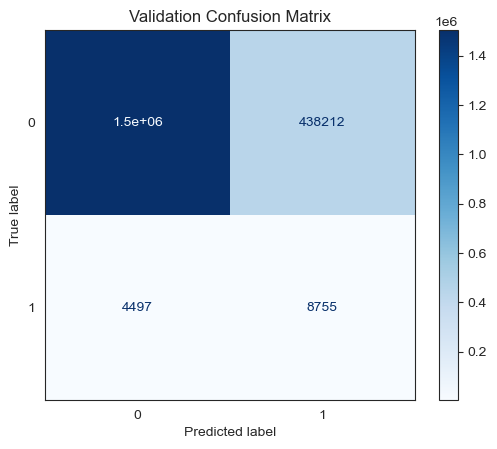

Validation AUC-ROC: 0.78


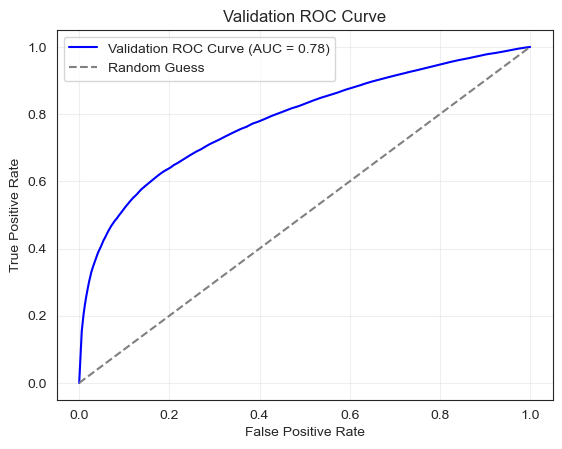

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = rf_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = rf_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

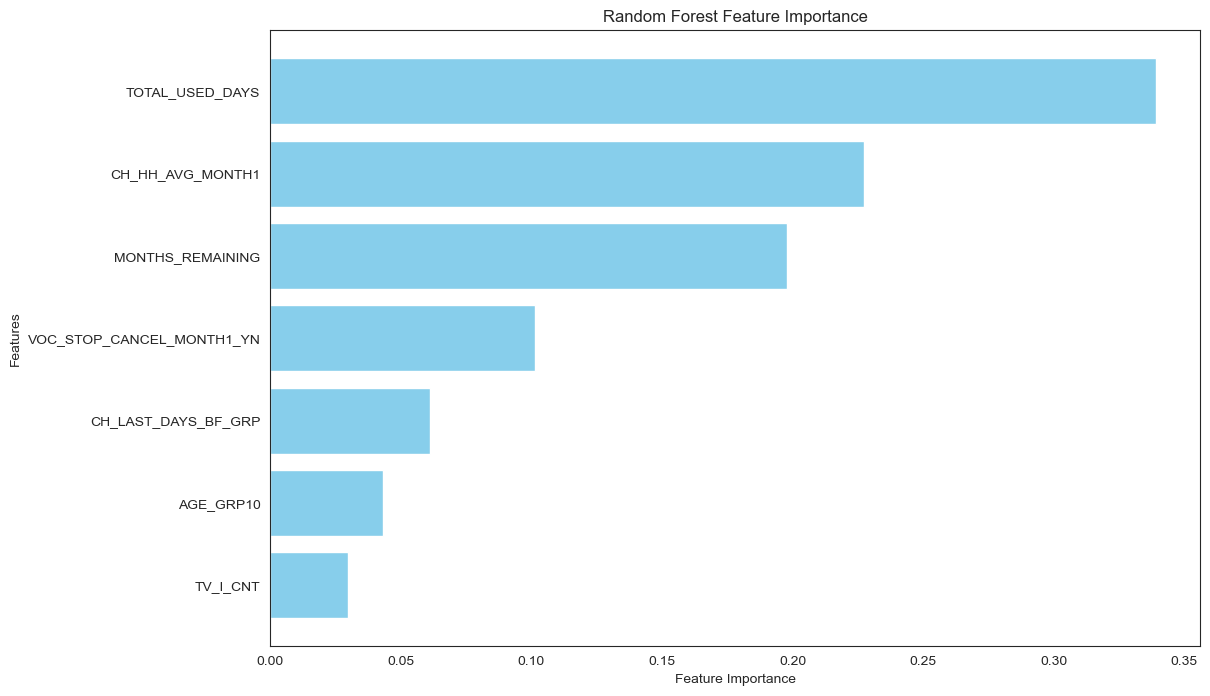

✅ Feature Importance
1. TOTAL_USED_DAYS
2. CH_HH_AVG_MONTH1
3. MONTHS_REMAINING
4. VOC_STOP_CANCEL_MONTH1_YN
5. CH_LAST_DAYS_BF_GRP
6. AGE_GRP10
7. TV_I_CNT


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importance = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 3. XGB 랜덤 언더 샘플링

In [24]:
from xgboost import XGBClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# XGBoost 모델 생성
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# 모델 학습
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.90   1941863
           1       0.02      0.68      0.05     13252

    accuracy                           0.81   1955115
   macro avg       0.51      0.75      0.47   1955115
weighted avg       0.99      0.81      0.89   1955115


Confusion Matrix (Validation):
[[1577522  364341]
 [   4230    9022]]


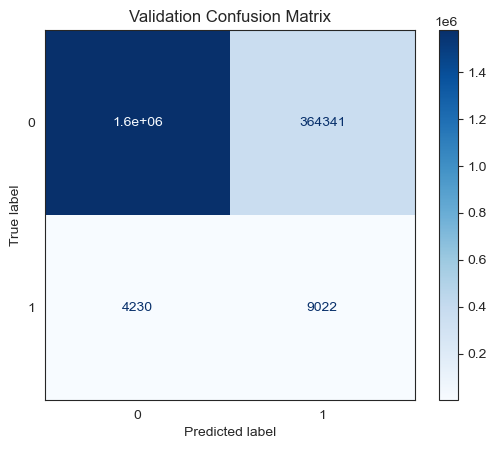

Validation AUC-ROC: 0.82


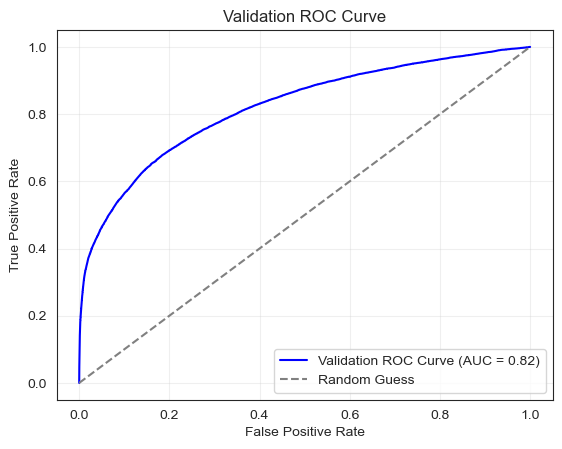

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = xgb_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = xgb_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

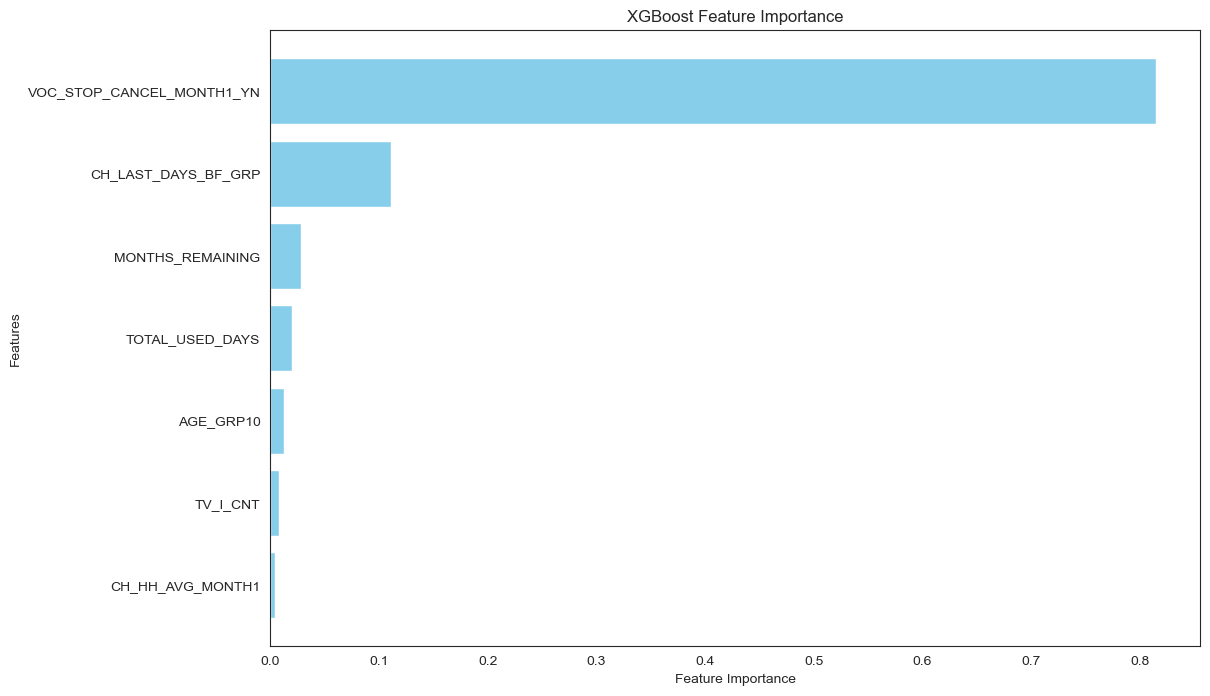

✅ Feature Importance
1. VOC_STOP_CANCEL_MONTH1_YN
2. CH_LAST_DAYS_BF_GRP
3. MONTHS_REMAINING
4. TOTAL_USED_DAYS
5. AGE_GRP10
6. TV_I_CNT
7. CH_HH_AVG_MONTH1


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# XGBoost Feature Importance 추출
feature_importance = xgb_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 4. LGBM 랜덤 언더 샘플링

In [27]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1941863
           1       0.02      0.68      0.05     13252

    accuracy                           0.81   1955115
   macro avg       0.51      0.75      0.47   1955115
weighted avg       0.99      0.81      0.89   1955115


Confusion Matrix (Validation):
[[1574882  366981]
 [   4212    9040]]


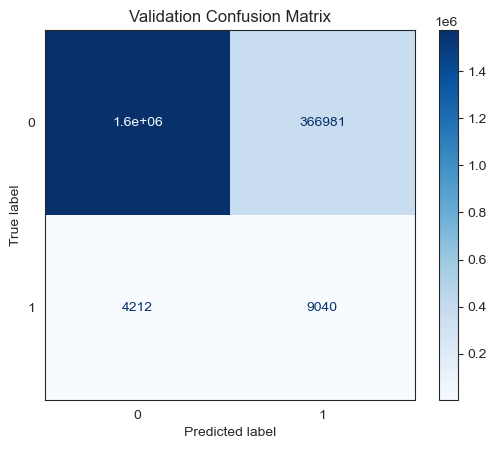

Validation AUC-ROC: 0.82


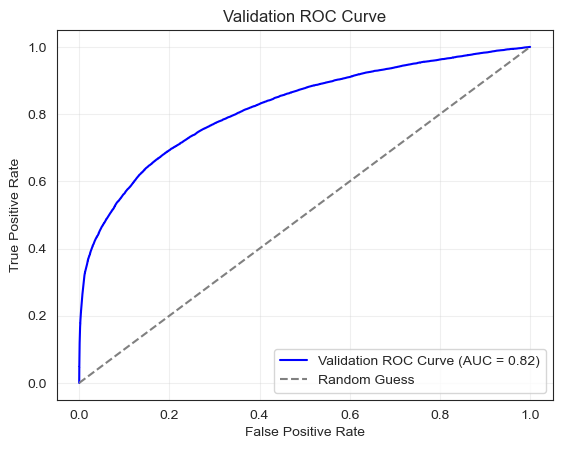

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

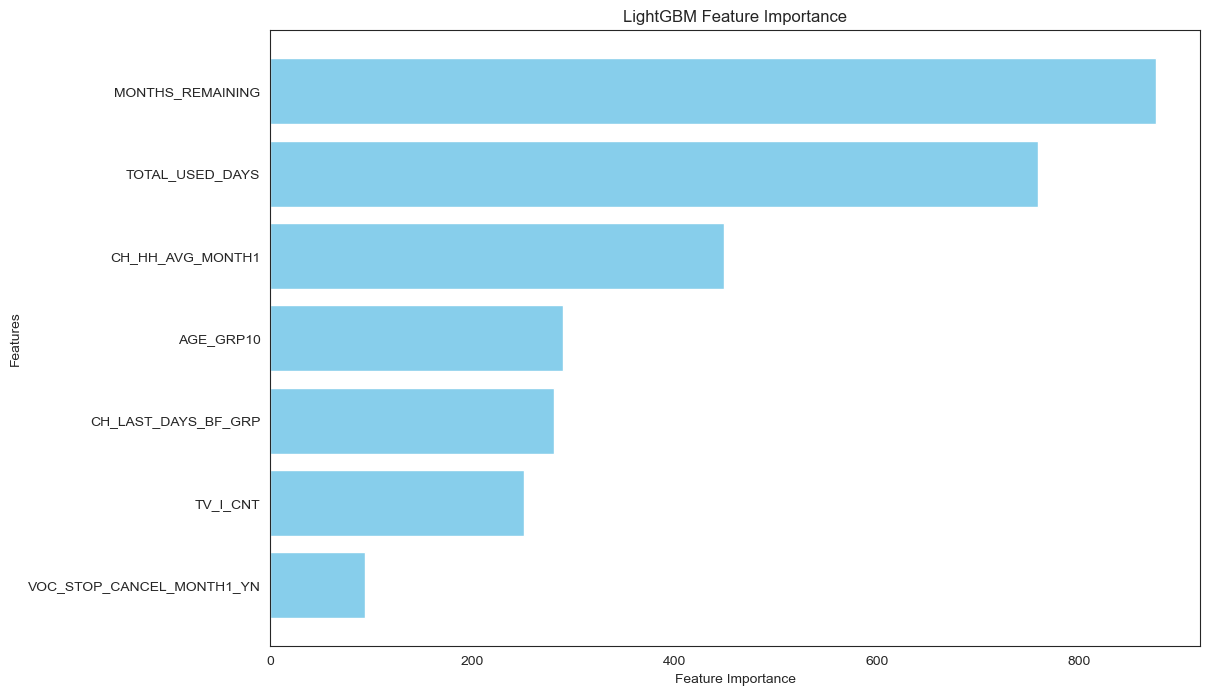

✅ Feature Importance
1. MONTHS_REMAINING
2. TOTAL_USED_DAYS
3. CH_HH_AVG_MONTH1
4. AGE_GRP10
5. CH_LAST_DAYS_BF_GRP
6. TV_I_CNT
7. VOC_STOP_CANCEL_MONTH1_YN


In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 5. CatBoost 랜덤 언더 샘플링

In [30]:
from catboost import CatBoostClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# 기본값을 사용한 CatBoost 모델 생성
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    random_seed=42
)

# 모델 학습
cat_model.fit(X_train, y_train)

0:	learn: 0.6803947	total: 182ms	remaining: 3m 1s
1:	learn: 0.6683705	total: 201ms	remaining: 1m 40s
2:	learn: 0.6571258	total: 222ms	remaining: 1m 13s
3:	learn: 0.6468183	total: 245ms	remaining: 1m
4:	learn: 0.6376561	total: 267ms	remaining: 53.1s
5:	learn: 0.6289806	total: 287ms	remaining: 47.5s
6:	learn: 0.6210968	total: 312ms	remaining: 44.2s
7:	learn: 0.6140231	total: 342ms	remaining: 42.4s
8:	learn: 0.6074425	total: 370ms	remaining: 40.7s
9:	learn: 0.6011481	total: 389ms	remaining: 38.5s
10:	learn: 0.5954022	total: 413ms	remaining: 37.1s
11:	learn: 0.5901437	total: 437ms	remaining: 35.9s
12:	learn: 0.5852919	total: 460ms	remaining: 34.9s
13:	learn: 0.5809005	total: 478ms	remaining: 33.7s
14:	learn: 0.5768803	total: 508ms	remaining: 33.4s
15:	learn: 0.5731104	total: 537ms	remaining: 33s
16:	learn: 0.5694866	total: 562ms	remaining: 32.5s
17:	learn: 0.5660625	total: 581ms	remaining: 31.7s
18:	learn: 0.5629189	total: 612ms	remaining: 31.6s
19:	learn: 0.5599640	total: 644ms	remaining:

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.90   1941863
           1       0.02      0.68      0.05     13252

    accuracy                           0.81   1955115
   macro avg       0.51      0.75      0.47   1955115
weighted avg       0.99      0.81      0.89   1955115


Confusion Matrix (Validation):
[[1577534  364329]
 [   4228    9024]]


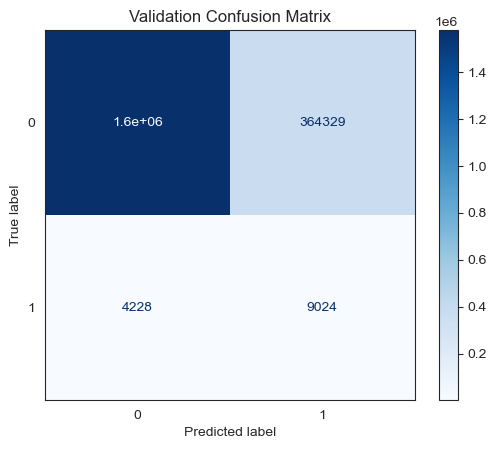

Validation AUC-ROC: 0.82


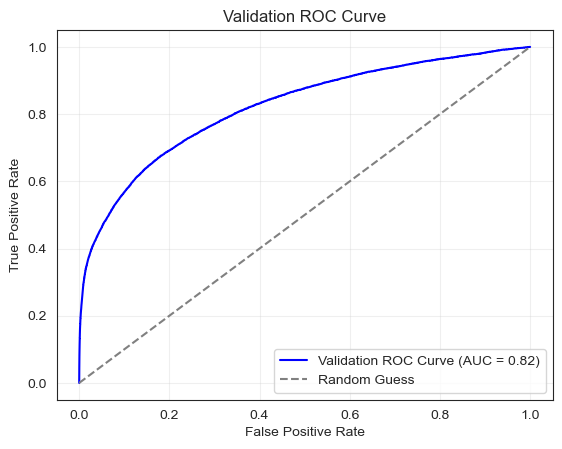

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = cat_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cat_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = cat_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

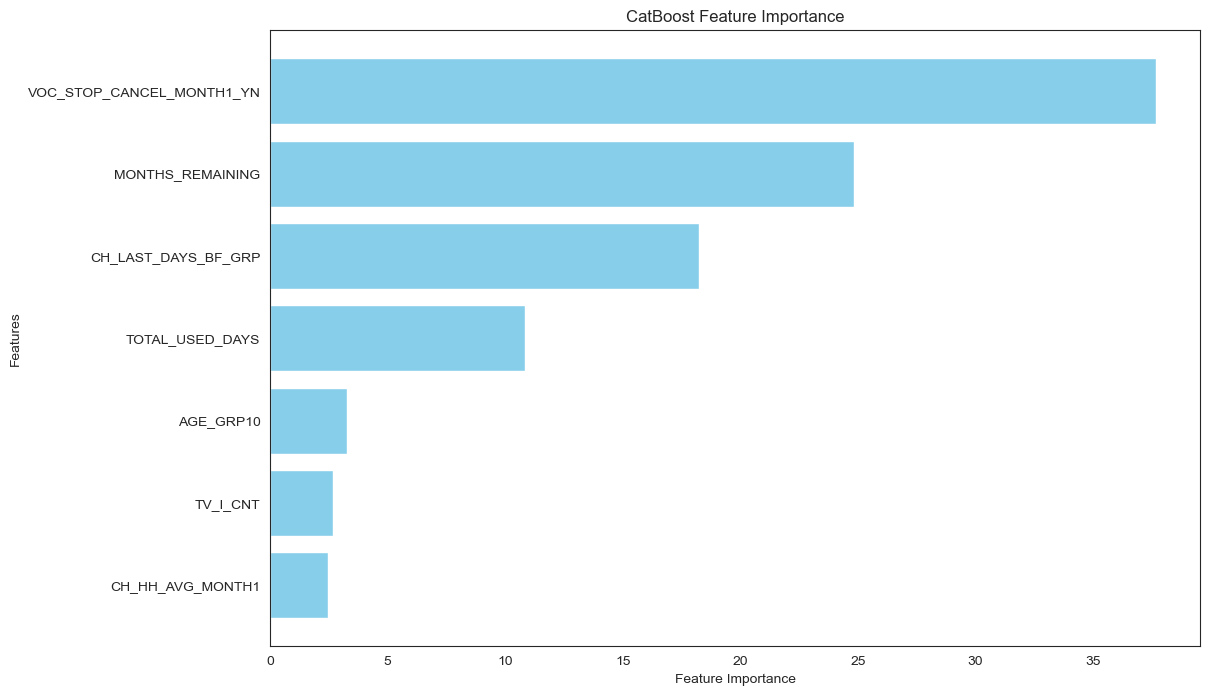

✅ Feature Importance
1. VOC_STOP_CANCEL_MONTH1_YN
2. MONTHS_REMAINING
3. CH_LAST_DAYS_BF_GRP
4. TOTAL_USED_DAYS
5. AGE_GRP10
6. TV_I_CNT
7. CH_HH_AVG_MONTH1


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# CatBoost Feature Importance 추출
feature_importance = cat_model.get_feature_importance()

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

### 가중치로 진행
1. 로지스틱
2. LGBM

#### 1. LR 가중치

In [33]:
# 2월 ~ 9월 train
# 6월 val
# 11월 test
train = df[df['p_mt'].isin([2,3,4,5,7,8,9])]
val = df[df['p_mt'] == 6]
test = df[df['p_mt'] == 11]

In [34]:
train

,sha2_hash,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,733,3.00,3개월내없음,N,60대,0.00,13,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,764,3.00,일주일내,N,60대,6.72,12,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,794,3.00,3주일전,N,60대,9.86,11,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,825,3.00,4주일전,N,60대,5.95,10,5,N
5,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,886,3.00,일주일내,N,60대,2.93,8,7,N
...,...,...,...,...,...,...,...,...,...,...
21483370,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2215,1.00,일주일내,N,50대,2.42,-36,4,N
21483371,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2246,1.00,일주일내,N,50대,3.67,-37,5,N
21483373,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2307,1.00,일주일내,N,50대,4.10,-39,7,N
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,2338,1.00,일주일내,N,50대,2.03,-40,8,N


In [36]:
train = train.drop(columns=['sha2_hash','p_mt'])
val = val.drop(columns=['sha2_hash','p_mt'])
test = test.drop(columns=['sha2_hash','p_mt'])

In [37]:
# 레이블 인코딩 진행!

from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object']).columns

# 레이블 인코딩 수행
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    val[col] = le.transform(val[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

print("레이블 인코딩 끝")

레이블 인코딩 끝


In [38]:
display(train)
display(val)
display(test)

,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,churn
0,733,3.00,1,0,5,0.00,13,0
1,764,3.00,4,0,5,6.72,12,0
2,794,3.00,2,0,5,9.86,11,0
3,825,3.00,3,0,5,5.95,10,0
5,886,3.00,4,0,5,2.93,8,0
...,...,...,...,...,...,...,...,...
21483370,2215,1.00,4,0,4,2.42,-36,0
21483371,2246,1.00,4,0,4,3.67,-37,0
21483373,2307,1.00,4,0,4,4.10,-39,0
21483374,2338,1.00,4,0,4,2.03,-40,0


,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,churn
4,855,3.00,4,0,5,4.03,9,0
15,4249,2.00,4,0,4,18.08,12,0
26,2488,6.00,4,0,5,1.09,25,0
37,1836,3.00,4,0,5,1.32,-5,0
48,3826,4.00,4,0,4,1.27,-46,0
...,...,...,...,...,...,...,...,...
21483328,3446,2.00,0,0,4,1.72,-43,0
21483339,2128,3.00,4,0,3,2.12,-34,0
21483350,3805,2.00,4,0,2,0.73,-104,0
21483361,1399,2.00,4,0,4,4.37,24,0


,TOTAL_USED_DAYS,TV_I_CNT,CH_LAST_DAYS_BF_GRP,VOC_STOP_CANCEL_MONTH1_YN,AGE_GRP10,CH_HH_AVG_MONTH1,MONTHS_REMAINING,churn
9,1008,3.00,4,0,5,6.23,33,0
20,4402,2.00,4,0,4,15.37,7,0
31,2641,6.00,4,0,5,1.47,20,0
42,1989,3.00,4,0,5,2.16,-10,0
53,3979,4.00,4,0,4,1.64,-51,0
...,...,...,...,...,...,...,...,...
21483333,3599,2.00,1,0,4,0.00,-48,0
21483344,2281,3.00,4,0,3,1.81,-39,0
21483355,3958,2.00,4,0,2,1.69,-109,0
21483366,1552,2.00,4,0,4,3.39,19,0


In [39]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# 내가 정한 robust 스케일링 컬럼들
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1','MONTHS_REMAINING']  # RobustScaler를 적용할 컬럼
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지 컬럼

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

# 결과 확인
print("robust, minmax 끝")

robust, minmax 끝


In [40]:
# 로지스틱 회귀 모델 진행

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train = train.drop(columns=['churn'])
y_train = train['churn']

# 로지스틱 회귀 모델 생성
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)

# 모델 학습
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

Validation Accuracy: 0.79

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.79      0.88   1941863
           1       0.02      0.63      0.04     13252

    accuracy                           0.79   1955115
   macro avg       0.51      0.71      0.46   1955115
weighted avg       0.99      0.79      0.88   1955115


Confusion Matrix (Validation):
[[1535583  406280]
 [   4934    8318]]


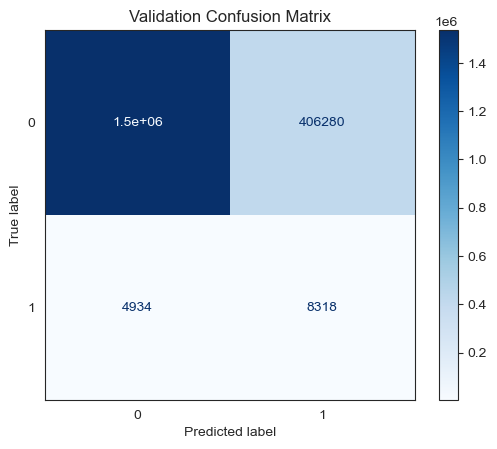

Validation AUC-ROC: 0.77


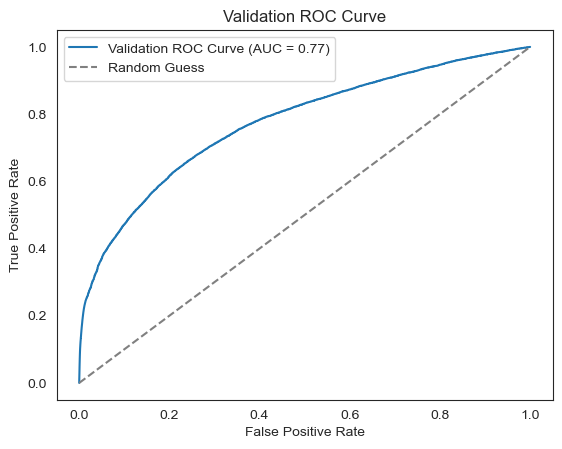

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_predictions))
disp_val = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=model.classes_)

# Confusion Matrix
plt.figure()
disp_val.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Validation Confusion Matrix")
plt.show()

# AUC-ROC 계산 및 시각화
val_probabilities = model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

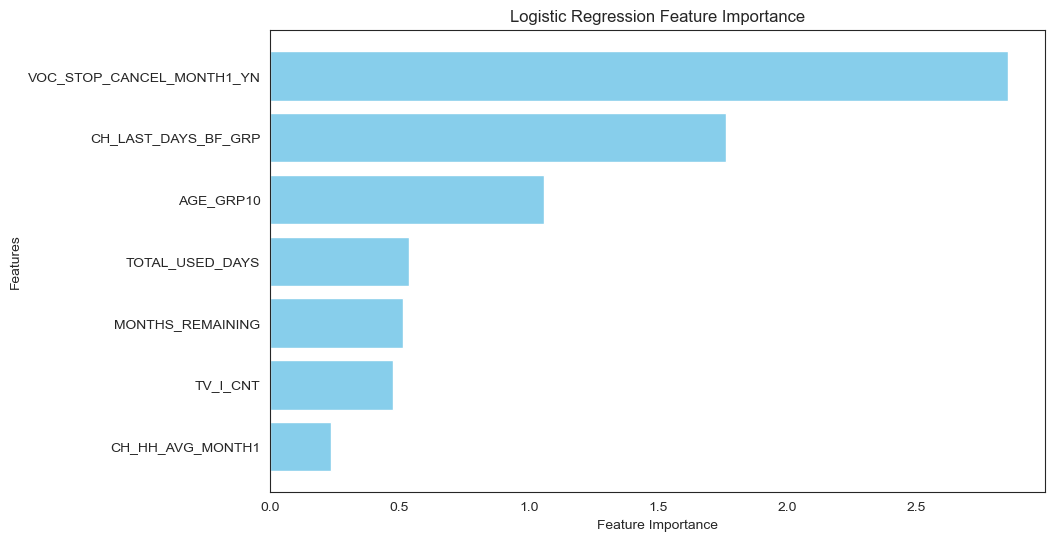

✅ Feature Importance
1. VOC_STOP_CANCEL_MONTH1_YN
2. CH_LAST_DAYS_BF_GRP
3. AGE_GRP10
4. TOTAL_USED_DAYS
5. MONTHS_REMAINING
6. TV_I_CNT
7. CH_HH_AVG_MONTH1


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = np.abs(model.coef_[0])

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Logistic Regression Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

#### 2. LGBM 가중치

In [48]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    learning_rate=0.1,
    class_weight='balanced',  # 클래스 가중치 적용
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

Validation Accuracy: 0.81

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1941863
           1       0.02      0.68      0.05     13252

    accuracy                           0.81   1955115
   macro avg       0.51      0.75      0.47   1955115
weighted avg       0.99      0.81      0.89   1955115


Confusion Matrix (Validation):
[[1574463  367400]
 [   4190    9062]]


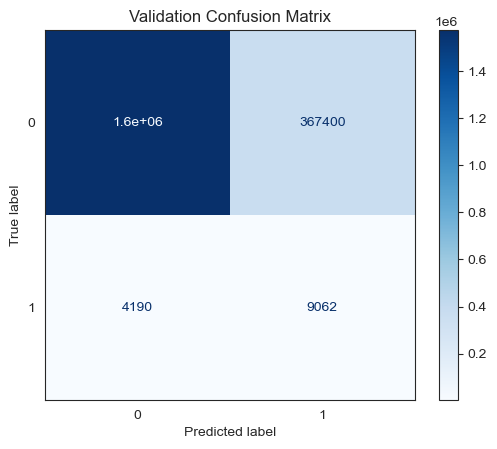

Validation AUC-ROC: 0.82


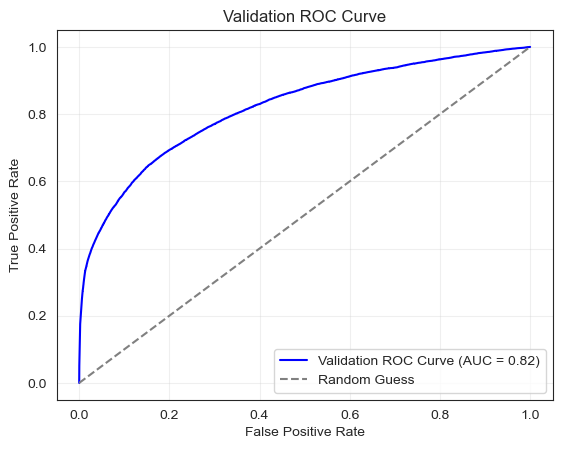

In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

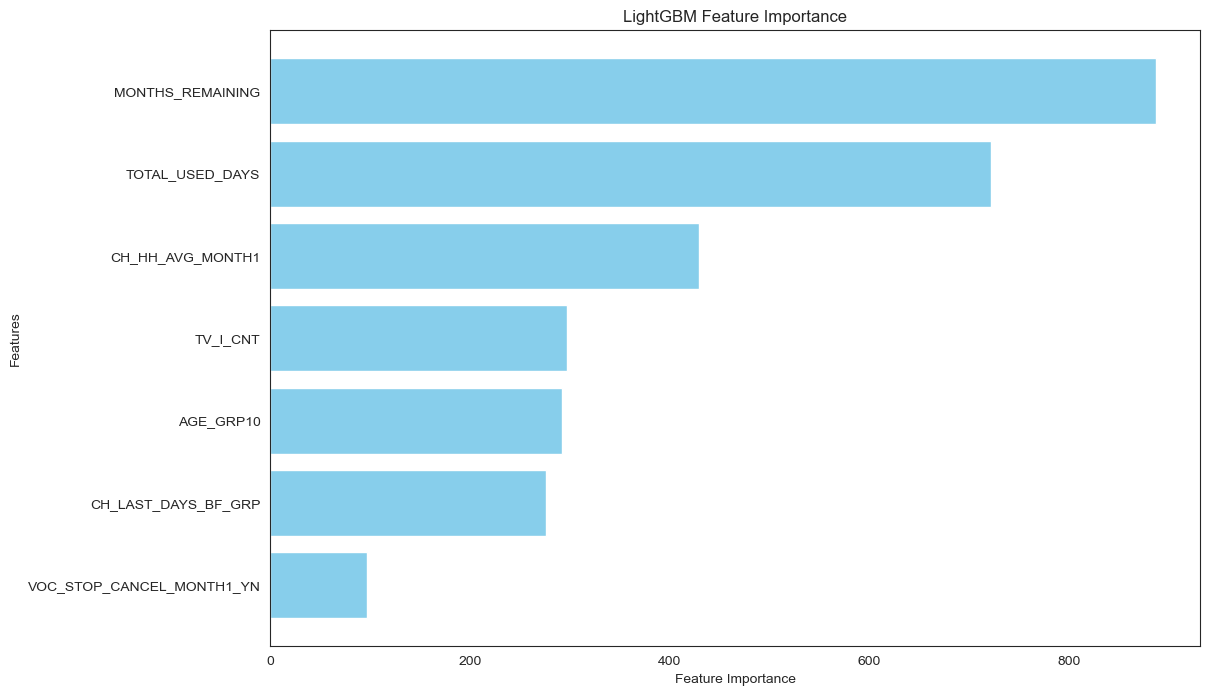

✅ Feature Importance
1. MONTHS_REMAINING
2. TOTAL_USED_DAYS
3. CH_HH_AVG_MONTH1
4. TV_I_CNT
5. AGE_GRP10
6. CH_LAST_DAYS_BF_GRP
7. VOC_STOP_CANCEL_MONTH1_YN


In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# LightGBM Feature Importance 추출
feature_importance = lgbm_model.feature_importances_

# DataFrame 변환 및 정렬
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.show()

print("✅ Feature Importance")
for rank, feature in enumerate(feature_importance_df['Feature'], 1):
    print(f"{rank}. {feature}")

---

01_14_LGHV_Modeling_afterFE2.ipynb 파일에서 했던 컬럼들로 모델링하는 편이 좀 더 나아보인다.